In [1]:
import rpy2

In [2]:
%load_ext rpy2.ipython

###Method of moment

Calculate k (try with different values, *should also change $\beta$*) and then $\bar{\gamma}$

In [3]:
%%R
source("scripts/TADA/TADA.R")
#ASC data
#We start with LoF mutations

data <- read.csv("data/nature_aut_id_epi.merged.txt", header = TRUE, sep = " ")
ntrio <- 2270 + 32 + 0 + 2508 ##AUT
ntrio <- ntrio + 0 + 356 #add EPI
ntrio <- ntrio + 100 + 0 + 41 + 51 ##add ID samples
ncase <- 1601 #Only from AUT paper
nctrl <- 5397  #Only from AUT paper
ntrans <- 1298 ##Check this information, Only use transmitted information from AUT paper nature13772


m <- nrow(data)

mu <- (data$mut.rate)*0.074 ##Mutation rates for each gene

C <- sum(data$dn.LoF) #total number of de novo LoF mutations
M.obs <- sum(data$dn.LoF > 1) #number of multiple-hit genes

print(M.obs)

head(data, 2)

[1] 65
  Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3 case.mis3
1 A1BG 2.36e-05      0        0        1         0          0       0         0
2 A1CF 2.17e-05      0        1        2         1          1       0         0
  ctrl.mis3 trans.mis3 ntrans.mis3     BF.dn        BF qvalue.dn    qvalue
1         4          7           3 0.7641762 0.5495361 0.9308429 0.9132353
2         7          3           7 0.7799631 0.7549958 0.9294060 0.8841540


In [4]:
%%R
#MOM estimation: choose the value of k (the number of risk genes) so that the expected number of multiple-hit
#genes is closest to the observed number

#The results are: #risk genes and the average RR

#Note: the value of beta usually has small influence, so we fix its value. But one could try different values, 
#e.g., from 0.1 to 10.

k.vec <- 100*6:14

beta <- 1
M <- numeric(length(k.vec))

##We go through all these k values, and then choose a value being closest M.obs
for (k.idx in 1:length(k.vec)){
    k <- k.vec[k.idx]
    M[k.idx] <- denovo.MOM(ntrio, mu, C, beta, k)$M
}

idx.k <- which.min(abs(M - M.obs))

k.est <- k.vec[idx.k] ##Estimated number of risk genes, and then re-run the function denovo.MOM

#k.est <- 1000 is a value in Section 8 of Text S1 of He et al. (2013)

gamma.mean.est <- denovo.MOM(ntrio, mu, C, beta, k.est)$gamma.mean #estimated RR of de novo LoF mutations

message("k.est: ", k.est, "\ngamma.mean.est: ", gamma.mean.est, "\nk.est/Gene#: ", k.est/18900)

k.est: 1400
gamma.mean.est: 14.1492011895366
k.est/Gene#: 0.0740740740740741


####Try with different $\beta$

In [5]:
%%R

k.vec <- seq(500, 1500, by = 10)

beta.array <- seq(0.1, 5, by = 0.025)

temp.MOM <- function(x, y) return(list(k.vec = y, beta = x, M= denovo.MOM(N= ntrio, mu = mu, C = C, beta = x, k = y)$M))
    
M.temp <- mapply(temp.MOM, beta.array, k.vec)

    dim(M.temp)

[1]   3 197


In [6]:
%%R
M.temp.k <- as.numeric(M.temp[3, ])

M.temp.k.idx <- which.min(abs(M.temp.k - M.obs))


M.temp.est <- as.numeric(M.temp[1, M.temp.k.idx])
beta.temp <- as.numeric(M.temp[2, M.temp.k.idx]    )
message("M.temp.est: ", M.temp.est, "\nbeta.temp: ", beta.temp)

M.temp.est: 1380
beta.temp: 4.825


In [7]:
%%R
#Re-calculate gamma.mean.est with new k.est

k.est <- as.numeric(M.temp.est)

gamma.mean.est <- denovo.MOM(ntrio, mu, C, beta = beta.temp, k.est)$gamma.mean #estimated RR of de novo LoF mutations

message("k.est: ", k.est, 
        "\nk.est/Gene#: ", k.est/m,
       "\ngamma.mean.est: ", gamma.mean.est, 
       "\nbeta.LoF: ", beta.temp)

k.est: 1380
k.est/Gene#: 0.0736589271417134
gamma.mean.est: 14.3397693227183
beta.LoF: 4.825


In [8]:
%%R
message(k.est, "\nm: ", m)


1380
m: 18735


###Use new k, $\beta$ to calculate for mis3

In [9]:
%%R
#RR for mis3 mutations

mu.mis3 <- (data$mut.rate)*0.32
C.mis3 <- sum(data$dn.mis3)
beta.mis3 <- 1.0
beta.mis3 <- beta.temp
gamma.mean.mis3.est <- denovo.MOM(ntrio, mu.mis3, C.mis3, beta.mis3, k.est)$gamma.mean

message("k.est: ", k.est, 
        "\nk.est/Gene#: ", k.est/m,
   #     "\pi: ", 1 - k.est/m,
        "\ngamma.mean.mis3.est: ", gamma.mean.mis3.est, 
       "\nbeta.mis3: ", beta.mis3)

k.est: 1380
k.est/Gene#: 0.0736589271417134
gamma.mean.mis3.est: 2.33970540837597
beta.mis3: 4.825


##Hyperparameters

###gamma.mean.dn = c(gamma.mean.est, gamma.mean.mis3.est)

###beta.dn = c(beta.LoF, beta.mis3)

In [13]:
%%R
denovo.MOM

function(N, mu, C, beta, k) {
  m <- length(mu) # number of genes
  
  # enrichment of de novo events
  nu <- C / (2 * N * sum(mu))
  
  # MOM estimator of gamma.mean
  gamma.mean <- (nu-1)*m/k +1
  
  # expected M (choose d = 2)
  rs <- count.multihit(N, mu, k/m, gamma.mean, beta, d=2)    
  M <- sum(rs$M1) + sum(rs$M0)
  
  return (list(gamma.mean=gamma.mean, M=M))
}


###Estimation of RR of inherited variants using a set of know disease genes. The RR is approximately 
###the enrichment of the LoF and mis3 counts in cases vs. in controls

In [67]:
%%R
ntrio <- 2231
ncase <- 1601
nctrl <- 5397
ntrans <- 1333
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
ASDgenes.table <- read.csv("TADA/data/known_ASD_genes.26genes.csv", header = TRUE, as.is = TRUE)


ASDgenes <- data.frame(Gene = subset(ASDgenes.table, label ==1)$gene)

data.ASDgenes <- merge(data, ASDgenes, by = "Gene")


In [68]:
%%R
#Case-control
q.LoF.case <- sum(data.ASDgenes$case.LoF + data.ASDgenes$trans.LoF)/(ncase + ntrans)
q.LoF.ctrl <- sum(data.ASDgenes$ctrl.LoF + data.ASDgenes$ntrans.LoF)/(nctrl + ntrans)

message("q.LoF.case: ", q.LoF.case,
       "\nq.LoF.ctrl: ", q.LoF.ctrl, "\n")

message("q.LoF.case/q.LoF.ctrl: ", q.LoF.case/q.LoF.ctrl)

q.mis3.case <- sum(data.ASDgenes$case.mis3 + data.ASDgenes$trans.mis3)/(ncase + ntrans)
q.mis3.ctrl <- sum(data.ASDgenes$ctrl.mis3 + data.ASDgenes$ntrans.mis3)/(nctrl + ntrans)

message("q.mis3.case/q.mis3.ctrl: ", q.mis3.case/q.mis3.ctrl)

sum(data.ASDgenes$case.LoF)/sum(data.ASDgenes$ctrl.LoF)

dim(data.ASDgenes)

q.LoF.case: 0.00988411724608044
q.LoF.ctrl: 0.00430906389301635

q.LoF.case/q.LoF.ctrl: 2.29379686434901
q.mis3.case/q.mis3.ctrl: 0.864531340970448
[1] 26 12


###Re-sampling to test gamma.mean.cc

In [69]:
%%R
ASDgenes <- data.frame(Gene = subset(ASDgenes.table, label ==1)$gene)

data.ASDgenes <- merge(data, ASDgenes, by = "Gene")

list.gamma.mean.cc.lof <- NULL
list.gamma.mean.cc.mis3 <- NULL

##########
data.ASDgenes <- merge(data, ASDgenes, by = "Gene")

NN <- 110000
nGene <- dim(data)[1]

out.Gamma <- lapply(1:NN, function(ii){
    
    list.Number <- sample(26, 1:nGene)
    temp.data <- data[list.Number, ]
    
    data.ASDgenes <- temp.data


q.LoF.case <- sum(data.ASDgenes$case.LoF + data.ASDgenes$trans.LoF)/(ncase + ntrans)
q.LoF.ctrl <- sum(data.ASDgenes$ctrl.LoF + data.ASDgenes$ntrans.LoF)/(nctrl + ntrans)

    
q.mis3.case <- sum(data.ASDgenes$case.mis3 + data.ASDgenes$trans.mis3)/(ncase + ntrans)
q.mis3.ctrl <- sum(data.ASDgenes$ctrl.mis3 + data.ASDgenes$ntrans.mis3)/(nctrl + ntrans)

    list.gamma.mean.cc.lof <- q.LoF.case/q.LoF.ctrl
    list.gamma.mean.cc.mis3 <- q.mis3.case/q.mis3.ctrl
    return(c(list.gamma.mean.cc.lof, list.gamma.mean.cc.mis3))
    })



gamma.cc.lof: 0.943699901159364
gamma.cc.mis3: 1.28299061778678


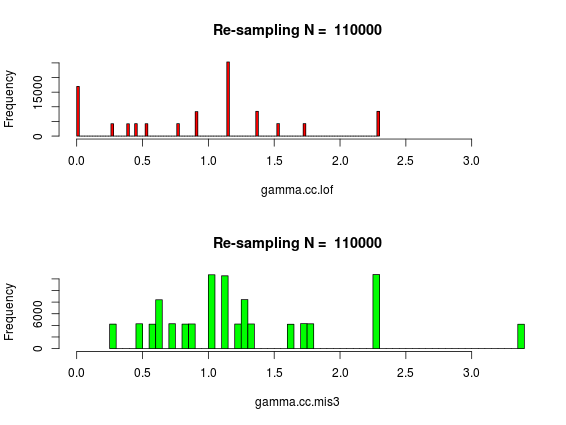

In [70]:
%%R -w 20 -h 15 -u cm
all.gamma <- do.call(rbind, out.Gamma)
gamma.cc.lof <- all.gamma[, 1]
gamma.cc.mis3 <- all.gamma[, 2]
allRange <- c(gamma.cc.lof, gamma.cc.mis3)
allRange <- range(allRange[!is.na(allRange)])

message("gamma.cc.lof: ", mean(gamma.cc.lof[!is.na(gamma.cc.lof)]))
message("gamma.cc.mis3: ", mean(gamma.cc.mis3[!is.na(gamma.cc.mis3)]))

par(mfrow = c(2, 1))
hist(gamma.cc.lof, 100, xlim = allRange, col = 'red', main = paste("Re-sampling N = ", NN))
hist(gamma.cc.mis3, 100, xlim = allRange, col = 'green', main = paste("Re-sampling N = ", NN))

In [71]:
%%R

data.ASDgenes <- merge(data, ASDgenes, by = "Gene")
ASDgenes.table <- read.csv("TADA/data/known_ASD_genes.26genes.csv", header = TRUE, as.is = TRUE)


ASDgenes <- data.frame(Gene = subset(ASDgenes.table, label ==1)$gene)

data.ASDgenes0 <- merge(data, ASDgenes, by = "Gene")


##########

NN <- 110000
nGene <- dim(data.ASDgenes)[1]

out.Gamma <- lapply(1:NN, function(ii){
    
    list.Number <- sample(22, 1:nGene)
    temp.data <- data.ASDgenes0[list.Number, ]
    
    data.ASDgenes <- temp.data


q.LoF.case <- sum(data.ASDgenes$case.LoF + data.ASDgenes$trans.LoF)/(ncase + ntrans)
q.LoF.ctrl <- sum(data.ASDgenes$ctrl.LoF + data.ASDgenes$ntrans.LoF)/(nctrl + ntrans)

    
q.mis3.case <- sum(data.ASDgenes$case.mis3 + data.ASDgenes$trans.mis3)/(ncase + ntrans)
q.mis3.ctrl <- sum(data.ASDgenes$ctrl.mis3 + data.ASDgenes$ntrans.mis3)/(nctrl + ntrans)

    list.gamma.mean.cc.lof <- q.LoF.case/q.LoF.ctrl
    list.gamma.mean.cc.mis3 <- q.mis3.case/q.mis3.ctrl
    return(c(list.gamma.mean.cc.lof, list.gamma.mean.cc.mis3))
    })



     [,1]      [,2]
[1,]  NaN 0.3276853
[2,]  NaN 0.0000000
[3,]    0 0.0000000
[4,]  Inf 2.1845684
[5,]  Inf 2.2937969
[6,]  Inf 0.4722523
gamma.cc.lof: 1.48014420898355
gamma.cc.mis3: 0.831500289993456


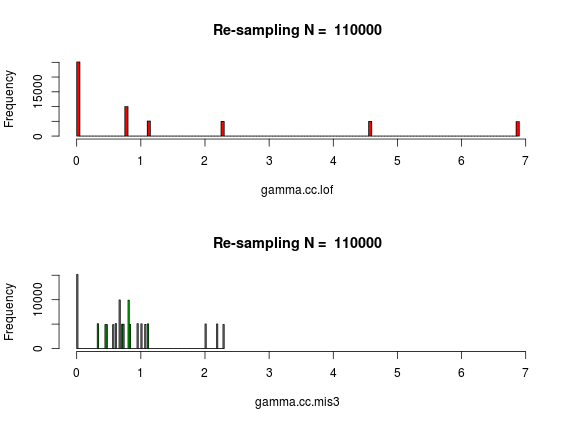

In [72]:
%%R -w 20 -h 15 -u cm
all.gamma <- do.call(rbind, out.Gamma)
print(head(all.gamma))
gamma.cc.lof <- all.gamma[, 1]
gamma.cc.lof <- gamma.cc.lof[!is.na(gamma.cc.lof)]
gamma.cc.lof <- gamma.cc.lof[!is.infinite(gamma.cc.lof)]

gamma.cc.mis3 <- all.gamma[, 2]
gamma.cc.mis3 <- gamma.cc.mis3[!is.na(gamma.cc.mis3)]
gamma.cc.mis3 <- gamma.cc.mis3[!is.infinite(gamma.cc.mis3)]

allRange <- c(gamma.cc.lof, gamma.cc.mis3)
allRange <- allRange[!is.na(allRange)]
allRange <- allRange[!is.infinite(allRange)]
allRange <- range(allRange[!is.na(allRange)])

message("gamma.cc.lof: ", mean(gamma.cc.lof[!is.na(gamma.cc.lof)]))
message("gamma.cc.mis3: ", mean(gamma.cc.mis3[!is.na(gamma.cc.mis3)]))

par(mfrow = c(2, 1))
hist(gamma.cc.lof, 100, xlim = allRange, col = 'red', main = paste("Re-sampling N = ", NN))
hist(gamma.cc.mis3, 100, xlim = allRange, col = 'green', main = paste("Re-sampling N = ", NN))

##Obtain hyperparameters $\bar{\gamma}_{CC}$ = gamma.mean.CC and $\beta_{CC}$ = beta.CC

###See: Model parameterization

If q.mis3.case/q.mis3.ctrl is ~ 1 => should choose gamma.mean.CC =1, beta.CC = 100

Other cases: beta.CC can be chosen (1, 5)


##Next, choose prior values for q

####H0

$q \sim Gamma(\bar{q_0} \nu_0, \nu_0) \sim Gamma(\rho_0, \nu_0)$

####H1

$q \sim Gamma(\bar{q_1} \nu_1, \nu_1) \sim Gamma(\rho_1, \nu_1)$

In [72]:
%%R
#Estimating the prior parameters of q: q ~ Gamma(q.mean*nu, nu).
#Note: we assume that q|H_1 and q|H_0 have the same prior.
#Only estimate the prior mean of q (q.mean), and choose nu to be a small number (e.g., 200)

q.LoF.mean <- mean(data$ctrl.LoF) /(nctrl)
q.mis3.mean <- mean(data$ctrl.mis3)/(nctrl + ntrans)

message("q.LoF.mean: ", q.LoF.mean, "\nq.mis3.mean: ", q.mis3.mean)

nu1.LoF <- 200
nu1.mis3 <- 100

rho1.LoF <- nu1.LoF*q.LoF.mean
rho1.mis3 <- nu1.mis3*q.mis3.mean

message("\nrho1.LoF: ", rho1.LoF,
       "\nrho1.mis3: ", rho1.mis3)


q.LoF.mean: 0.00034023389423663
q.mis3.mean: 0.00152477801954293

rho1.LoF: 0.0680467788473259
rho1.mis3: 0.152477801954293


In [75]:
%%R
mean(data$ctrl.LoF + data$case.LoF)/(nctrl + ntrans)

[1] 6.374282


In [15]:
#!gist -p Estimate_hyperparameters_TADA_extDATA.ipynb

In [16]:
!gist -u https://gist.github.com/3961775f97baa5b00ba2 Estimate_hyperparameters_TADA_extDATA.ipynb

https://gist.github.com/3961775f97baa5b00ba2


In [63]:
%%R
# ASD data
data <- read.csv("data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  
ncase <- 1601  
nctrl <- 5397  
ntrans <- 1333

# Estimation of RR of inherited variants using a set of known disease genes. The RR is approximately the enrichment of the LoF and mis3 counts in cases vs. in controls
ASDgenes.table <- read.csv("data/known_ASD_genes.26genes.csv", header=TRUE, as.is=TRUE)
ASDgenes <- data.frame(Gene=subset(ASDgenes.table, label==1)$gene)
data.ASDgenes <- merge(data, ASDgenes, by="Gene")
# Case-control
q.LoF.case <- sum(data.ASDgenes$case.LoF)/(ncase)
q.LoF.ctrl <- sum(data.ASDgenes$ctrl.LoF)/(nctrl)

print(sum(data.ASDgenes$case.LoF))
print(sum(data.ASDgenes$ctrl.LoF))

print(q.LoF.case/q.LoF.ctrl)


q.mis3.case <- sum(data.ASDgenes$case.mis3)/ncase
q.mis3.ctrl <- sum(data.ASDgenes$ctrl.mis3)/nctrl

print(q.mis3.case/q.mis3.ctrl)

# Estimating the prior parameters of q: q ~ Gamma(q.mean*nu, nu). 
# Note: we assume that q|H_1 and q|H_0 have the same prior. 
# Only estimate the prior mean of q (q.mean), and choose nu to be a small number (e.g. 200)
q.LoF.mean <- mean(data$ctrl.LoF)/nctrl
q.mis3.mean <- mean(data$ctrl.mis3)/nctrl




[1] 27
[1] 22
[1] 2.430767
[1] 0.8329929


In [49]:
%%R
data.ASDgenes

      Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1  CACNA1C 1.134e-04      0        1        3         0          0       0
2     CHD7 1.190e-04      0        1        2         0          0       1
3     CHD8 9.250e-05      3        4        0         0          0       2
4  CNTNAP2 5.750e-05      0        0        1         0          0       0
5     CUL3 2.977e-05      2        2        0         0          0       0
6   DLGAP2 6.540e-05      0        1        0         0          0       0
7   DYRK1A 3.119e-05      4        0        0         0          0       0
8    EPHB2 5.760e-05      1        0        2         0          2       0
9     FMR1 2.360e-05      0        0        2         0          0       0
10   FOXP1 3.015e-05      1        0        0         0          1       0
11  GRIN2B 7.300e-05      3        3        1         0          0       0
12 KATNAL2 2.003e-05      2        3        4         1          0       0
13    MBD5 5.320e-05     

In [47]:
%%R
q.LoF.case

[1] 0.01686446


In [48]:
%%R
q.LoF.mean

[1] 0.0003402339


In [78]:
%%R

data <- read.csv("data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, as.is = TRUE)

counts <- as.array(cbind(data$dn.LoF, ##Xd
                         data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, ##X1, X0
                         data$dn.mis3, 
                         data$case.mis3+data$trans.mis3, data$ctrl.mis3+data$ntrans.mis3))

data <- read.csv("data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

head(data, 2)

  Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1 A1BG 2.355e-05      0        0        1         0          0       0
2 A1CF 2.174e-05      0        1        2         1          1       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3
1         0         4          7           3
2         0         7          3           7


In [80]:
%%R

source("TADA.R")
data <- read.csv("data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, as.is = TRUE)

counts <- as.array(cbind(data$dn.LoF, ##Xd
                         data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, ##X1, X0
                         data$dn.mis3, 
                         data$case.mis3+data$trans.mis3, data$ctrl.mis3+data$ntrans.mis3))

data <- read.csv("data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

# Parameters: set your values
#N <- list(dn=967, ca=617+2536, cn=617+2543) 
#data<-read.table("scz.dat", header=T)
#data <- data[data$mis_trans<100 & data$mis_untrans<100 & data$mis_case<100 & data$mis_cont<100,]
#names(data)
# [1] "Gene"        "length"      "tot_mu"      "lof_mu"      "missense_mu"
# [6] "lof_dn"      "lof_trans"   "lof_untrans" "lof_case"    "lof_cont"   
#[11] "mis_dn"      "mis_trans"   "mis_untrans" "mis_case"    "mis_cont"   
#counts.LoF <- data.frame(ca=data$lof_case, cn=data$lof_cont)
#counts.mis <- data.frame(ca=data$mis_case, cn=data$mis_cont)

counts.LoF <- data.frame(ca = data$case.LoF, cn = data$ctrl.LoF)
counts.mis <- data.frame(ca = data$case.mis3, cn = data$ctrl.mis3)

# set pi? k~1000 => pi~0.05

#TADA: estiamte pi from whole-exome in three steps
# Step 1: estimating (rho0, nu0)
# Set pi.init to be a very small value (other parameters don't matter)
hyperpar.LoF.init <- c(10, 1, 2.5, 1, 0.5, 500, 0.5, 500)
lower.LoF <- c(2, 0.5, 2.0, 0.5, 0.1, 100, 0.1, 100)
upper.LoF <- c(30, 5, 10.0, 5, 5, 10000, 5, 10000)
pi.init <- 0.00001
est.option <- rep(FALSE, 8)
est.option[c(7,8)] <- TRUE # only estimate rho0 and nu0
est.pi <- FALSE
#empBayes.result.LoF <- empBayes(counts.LoF, N, data$lof_mu, hyperpar.LoF.init, pi.init, lower.LoF, upper.LoF, est.option=est.option, est.pi=est.pi, debug=TRUE)
empBayes.result.LoF <- empBayes(counts.LoF, N, data$mut.rate, 
                                hyperpar.LoF.init, pi.init, 
                                lower.LoF, upper.LoF, 
                                est.option=est.option, est.pi=est.pi, debug=TRUE)


#Parameters = (0.5, 500)                            Value = 47498.82
#Parameters = (0.500500250083354, 500)      Value = 47515.03
#Parameters = (0.499500249916688, 500)      Value = 47482.64
#Parameters = (0.5, 500.500250083354)       Value = 47490.3
#Parameters = (0.5, 499.500249916687)       Value = 47507.34
#Parameters = (0.1, 10000)                  Value = 54310.63
#Parameters = (0.100100050016671, 10000)            Value = 54301.67
#Parameters = (0.1, 10000)       Value = 54310.63
#Parameters = (0.1, 10000)       Value = 54310.63
#Parameters = (0.1, 9990.00499833376)   Value = 54300.13
#Parameters = (0.267820965041291, 1598.19650013888)     Value = 38588.7
#Parameters = (0.268088919961463, 1598.19650013888)     Value = 38587.01
#Parameters = (0.267553277942107, 1598.19650013888)     Value = 38590.4
#Parameters = (0.267820965041291, 1599.79549600371)     Value = 38587.95
# ...
#Parameters = (0.732672555710685, 5240.68962650498)     Value = 37335.13
#Parameters = (0.733405594724816, 5245.93293734996)     Value = 37335.13
#Parameters = (0.733405594724816, 5235.45155635006)     Value = 37335.13



Error: could not find function "evidence.alt"


In [81]:
%%R
empBayes

function(counts, N, mu, hyperpar.init, pi.init, lower, upper, lower.pi=1e-10, upper.pi=1, est.option=rep(FALSE, 8), est.pi=FALSE, prior.weight=0, debug=FALSE) {  
  # marginal likelihood function (parameters in log-scale)
  marginal.loglike <- function(subpar.log) {
    subpar <- exp(subpar.log)
    allpar <- subpar2fullpar(subpar, hyperpar.init, pi.init, est.option, est.pi)
    hyperpar <- allpar$hyperpar
    pi <- allpar$pi
    result <- marginal(hyperpar,  pi, counts, N, mu, prior.weight=prior.weight)$marginal  
    
    if (debug) {
      cat("Parameters = (", paste(subpar, collapse=", "), ")\tValue = ", result, "\n", sep="") 
    }
    
    return (result)
  }
  
  # no parameter to estimate
  if ( sum(est.option==TRUE) == 0 & est.pi == FALSE ) {
    value <- marginal(hyperpar.init, pi.init, counts, N, mu, prior.weight=prior.weight)$marginal
    return (list(hyperpar=hyperpar.init, value=value))
  }
  
  # initialize the sub. parameters
  subpar.init <- fullpar2subpar(hyperpar.ini

In [82]:
%%R
marginal

function(hyperpar, pi, counts, N, mu, prior.weight=0, denovo.only=FALSE, debug=FALSE) {
  gamma.mean.dn <- hyperpar[1]
  beta.dn <- hyperpar[2]
  gamma.mean.CC <- hyperpar[3]
  beta.CC <- hyperpar[4]
  rho1 <- hyperpar[5]
  nu1 <- hyperpar[6]
  rho0 <- hyperpar[7]
  nu0 <- hyperpar[8]
  
  n <- nrow(counts)
  prob <- numeric(n)
  posterior <- numeric(n)
  bf <- numeric(n)
  for (i in 1:n)  {
    if (debug) cat("i = ", i, "\tdn = ", counts[i,]$dn, "\tca = ", counts[i,]$ca, "\tcn = ", counts[i,]$cn, "\n")
    if (denovo.only==TRUE) {
      prob.M1 <- evidence.alt.dn(counts[i,"dn"], N$dn, mu[i], gamma.mean.dn, beta.dn) 
      prob.M0 <- evidence.null.dn(counts[i,"dn"], N$dn, mu[i])
    } else {
      prob.M1 <-  evidence.alt(counts[i,],N,mu[i],gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1)
      prob.M0 <-  evidence.null(counts[i,],N,mu[i],rho0, nu0) 
    }
    if (debug) cat("prob.M1 = ", prob.M1,"\n")
    if (debug) cat("Prob.M0 = ", prob.M0, "\n")
    prob[i] <- pi * prob.M

In [83]:
%%R
evidence.alt

Error in withVisible({ : object 'evidence.alt' not found
